In [1]:
# !pip install nashpy w

In [1]:
import numpy as np 
import nashpy as ne
from scipy.optimize import linprog 
import matplotlib.pyplot as plt 

In [2]:
def create_game_matrix(n_strategies):
    """Δημιουργεί τον πίνακα πληρωμής του παίκτη γραμμής με μοναδιμκό όρισμα τον αριθμό των δυνατών στρατηγικών. Ο παίκτης στήλης έχει πίνακα Β=-Α"""
    n = n_strategies
    A = np.zeros((n, n), dtype=int)

    rows, cols = np.indices((n, n))
    delta = cols - rows

    A[delta == 1] = -1
    A[delta > 1]  = 2
    A[delta == -1] = 1
    A[delta < -1] = -2

    return A 

In [4]:
A = create_game_matrix(7) 
print(A) 

[[ 0 -1  2  2  2  2  2]
 [ 1  0 -1  2  2  2  2]
 [-2  1  0 -1  2  2  2]
 [-2 -2  1  0 -1  2  2]
 [-2 -2 -2  1  0 -1  2]
 [-2 -2 -2 -2  1  0 -1]
 [-2 -2 -2 -2 -2  1  0]]


Παρατηρούμε πως η στον πίνακα Α του παίκτη γραμμής οι στρατηγικές του i>=4 είναι "ποτέ βέλτιστες", είναι δηλαδή ασθενώς κυριαρχημένες. Όπως θα δούμε και παρακάτω αυτό βγαίνει σαν συμπέρασμα και από τα αποτελέσματα των λύσεων των αντίστοιχων γραμμικών συστημάτων. Μπορούμε να χρησιμοποιήσουμε την απαλοιφή κυριαρχημένων στρατηγικών για να απλοποιήσουμε τον πίνακα Α.  

In [ ]:
def solve_game_with_nashpy(A):
    """
    Λύνει παίγνιο μηδενικού αθροίσματος με τη βιβλιοθήκη nashpy.
    
    Parameters:
        A (ndarray): Πίνακας πληρωμών του Παίκτη 1 (n x n)

    Returns:
        dict: Βέλτιστες μικτές στρατηγικές και τιμή παιγνίου
    """
    game = ne.Game(A, -A)  

    equilibria = list(game.support_enumeration())

    results = []
    for eq in equilibria:
        x, y = eq
        value = x @ A @ y
        results.append({
            "player_1_strategy": x,
            "player_2_strategy": y,
            "value": value
        })

    return results

In [6]:
# Παράδειγμα: Matching Pennies

solutions = solve_game_with_nashpy(A)

for i, sol in enumerate(solutions):
    print(f"Λύση {i+1}:")
    print("Στρατηγική Παίκτη 1:", sol["player_1_strategy"])
    print("Στρατηγική Παίκτη 2:", sol["player_2_strategy"])
    print("Τιμή παιγνίου:", sol["value"])

Λύση 1:
Στρατηγική Παίκτη 1: [0.25 0.5  0.25 0.   0.   0.   0.  ]
Στρατηγική Παίκτη 2: [0.25 0.5  0.25 0.   0.   0.   0.  ]
Τιμή παιγνίου: 0.0


In [7]:
from time import time 
def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        # print(f'Function {func.__name__!r} with m,n = {args[0].shape} executed in {(t2-t1):.4f}s')
        if isinstance(result, dict):
            result['runtime'] = t2-t1
            result['dimention'] = np.shape(args)[1]
        return result 
    return wrap_func

In [8]:
@timer_func
def solve_zero_sum_game(A):
    """
    Λύνει το πρόβλημα του Παίκτη 1 με χρήση γραμμικού προγραμματισμού.

    Parameters:
        A (ndarray): Πίνακας πληρωμών Παίκτη 1

    Returns:
        dict: Περιλαμβάνει στρατηγική Παίκτη 1, τιμή παιγνίου και επιτυχία
    """
    m, n = A.shape
    c = np.zeros(m + 1)
    c[-1] = -1  # Μεγιστοποίηση της τιμής του παιγνίου v

    A_ub = np.hstack([-A.T, np.ones((n, 1))])  # λ.T A ≤ v
    b_ub = np.zeros(n)

    A_eq = np.zeros((1, m + 1))
    A_eq[0, :-1] = 1
    b_eq = [1]

    bounds = [(0, None)] * (m + 1)

    res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    return {
        "success": res.success,
        "value": -res.fun if res.success else None,
        "strategy": res.x[:-1] if res.success else None,
        "status": res.message
    }

Θα δοκιμάσουμε διαφορετικά μεγέθη πινάκων για να δούμε πως αυξάνεται ο χρόνος υπολογισμού των βέλτιστων στρατηγικών προφίλ.

In [9]:
results = []
for i in range(2,25):
    n = create_game_matrix(i**2)
    A = (n)
    result = solve_zero_sum_game(A) 
    results.append(result) 

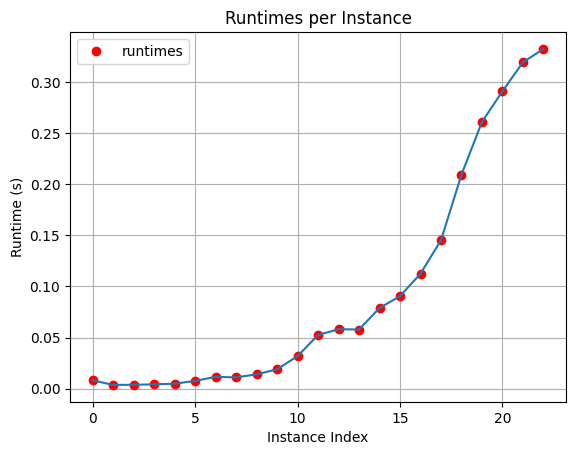

In [ ]:
runtimes = [entry['runtime'] for entry in results]

plt.plot(runtimes, "ro",label="runtimes" )
plt.plot(runtimes)

plt.legend()
plt.xlabel('Instance Index')
plt.ylabel('Runtime (s)')
plt.title('Runtimes per Instance')
plt.grid() 
plt.show() 

Πρατηρούμε ότι ο χρόνος αυξάνεται αρκετά γρήγορα για αυτό θα ρησιμοποιήσουμε την απαλοιφή τον ποτέ βέλτιστων στρατηγικών όπως αναφέραμε παραπάνω. Στο πρόβλημά μας θεωρητικά μπορούμε να απαλείψουμε όλες τις στήλες γραμμές από τη τεταρτη και μετά. Ο παρακάτω αλγόριθμος δουλεύει και για πίνακες που δεν αφορούν συγκεκριμμένα το πρόβλημα που παρουσιάζεται εδώ και βασίζεται στην ιδέα πως αν μια γραμμη κυριαρχεί ασθενώς πάνω σε μία άλλη, τότε κυριαρχεί και πανω σε όλες αυτές οι οποίες κυριαρχούνται απο αυτήν. Αν λοιπόν βρούμε κάποια που κυριαρχείται θα την θέσουμε ως αυτή με την οποία συγκρίνουμε μέχρι να τις συγκρίνουμε όλες. Θα τον τρέξουμε και θα δούμε πόσο βελτιώθηκε ο συνολικός χρόνος. 

In [ ]:

def remove_weakly_dominated_rows(A, strict=False):
    """
    Αφαιρεί γραμμές που είναι ασθενώς κυριαρχούμενες από άλλες.
    
    Αν strict=True, αφαιρεί μόνο αυστηρά κυριαρχούμενες γραμμές.
    Αν strict=False, εφαρμόζει και επαγωγική ασθενή κυριαρχία.
    
    """
    A = np.array(A, dtype=float)
    keep = np.ones(A.shape[0], dtype=bool)  # όλες οι γραμμές στην αρχή θεωρούνται χρήσιμες
    
    changed = True
    while changed:
        changed = False
        for i in range(A.shape[0]):
            if not keep[i]:
                continue
            for j in range(A.shape[0]):
                if i == j or not keep[j]:
                    continue
                # Έλεγχουμε κυριαρχία: γραμμή j κυριαρχεί τη γραμμή i
                if strict:
                    dominates = np.all(A[j] > A[i])
                else:
                    dominates = np.all(A[j] >= A[i]) and np.any(A[j] > A[i])
                if dominates:
                    keep[i] = False
                    changed = True
                    break  # ξαναξεκινάμε γιατί άλλαξε κάτι
    
    return A[keep]
 
def remove_weakly_dominated_columns(A, strict=False):
    return remove_weakly_dominated_rows(A.T, strict).T

In [13]:
np.shape(A) 

(576, 576)

In [33]:
@timer_func
def solve_reduced_game(A):
    A_red = remove_weakly_dominated_rows(A, strict=False)
    print(np.shape(A_red))
    # Για να απαλείψουμε τις κυριαρχημενες στρατηγικές του παίκτη στηλών θα πάρουμε τον Β=-Α
    B_red = remove_weakly_dominated_columns(-A_red, strict=False)
    print(np.shape(B_red)) 
    A_red = -B_red
    return solve_zero_sum_game(A_red)

In [34]:
results = []
print("shapes after reductions:\n")
for i in range(2,25):
    A = create_game_matrix(i**2)
    result = solve_reduced_game(A)  
    results.append(result) 
    

shapes after reductions:

(3, 4)
(3, 3)
(3, 9)
(3, 3)
(3, 16)
(3, 3)
(3, 25)
(3, 3)
(3, 36)
(3, 3)
(3, 49)
(3, 3)
(3, 64)
(3, 3)
(3, 81)
(3, 3)
(3, 100)
(3, 3)
(3, 121)
(3, 3)
(3, 144)
(3, 3)
(3, 169)
(3, 3)
(3, 196)
(3, 3)
(3, 225)
(3, 3)
(3, 256)
(3, 3)
(3, 289)
(3, 3)
(3, 324)
(3, 3)
(3, 361)
(3, 3)
(3, 400)
(3, 3)
(3, 441)
(3, 3)
(3, 484)
(3, 3)
(3, 529)
(3, 3)
(3, 576)
(3, 3)


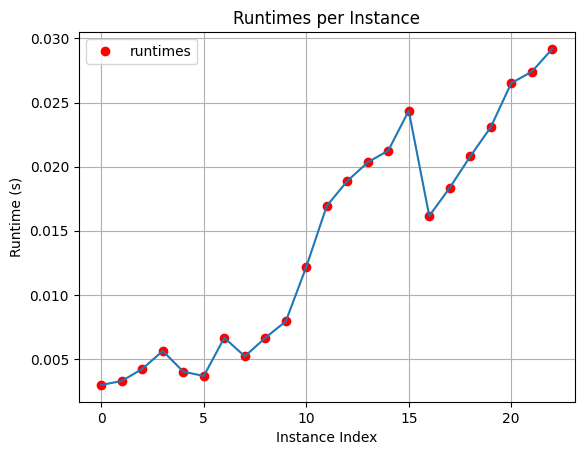

In [ ]:
runtimes = [entry['runtime'] for entry in results]

plt.plot(runtimes, "ro",label="runtimes" )
plt.plot(runtimes)

plt.legend()
plt.xlabel('Instance Index')
plt.ylabel('Runtime (s)')
plt.title('Runtimes per Instance')
plt.grid() 
plt.show() 

Παρατηρούμε ότι για μικρούς πίνακες το κόστος του υπολογισμού δεν μ,ειώνεται δραματικά. Ας δοκιμασουμε όμως και έναν μεγαλύτερο πίνακα.

In [37]:
A = create_game_matrix(1000)
r1 = solve_zero_sum_game(A) 
r2 = solve_reduced_game(A) 

(3, 1000)
(3, 3)


In [41]:
print("Non reduced:",r1["runtime"],"\n","Reduced:",r2["runtime"]) 

Non reduced: 1.191354751586914 
 Reduced: 0.05146169662475586


Η διαφορά είναι πλέον αισθητή!